# Hybrid flow shop

The hybrid flow shop (HFS) is a common manufacturing environment in practice and widely studied by scheduling researchers. See for example the surveys by [Ruiz and Vázquez-Rodríguez (2010)](https://www.sciencedirect.com/science/article/pii/S0377221709006390) and [Ribas et al. (2010)](https://www.sciencedirect.com/science/article/pii/S0305054809002883) for an overview of HFS studies.

In this notebook, we demonstrate how to model a HFS problem using PyJobShop. We also show how to model the _accessibility_ constraint, which is a common constraint in manufacturing systems that have physical transportation constraints.

## Problem description
The HFS problem is characterized as follows:
- There is a set of $n$ jobs that need to be processed in a series of stages.
- The number of processing stages is at least 2.
- Each stage has at least one machine in parallel, and in at least one stage there is more than one machine.
- All jobs are processed in the same production order: production starts in stage 1, then stage 2, etc. until the last stage. A job can only start processing when it has finished processing in the previous stage.

The figure below illustrates a small HFS example with three jobs and three stages. The first and third stage have three machines, and the second stage has two machines.

![HFS](../design/hybrid-flow-shop.png "HFS")

## Problem data
Let's now implement the simple example from above using PyJobShop.

In [62]:
import random

In [63]:
num_jobs = 3
num_stages = 3
num_machines = [3, 2, 3]

In [70]:
from pyjobshop import Model

model = Model()

jobs = [model.add_job() for _ in range(num_jobs)]


def machine_name(machine_idx, stage_idx):
    return f"$M_{{{machine_idx}{stage_idx}}}$"


stage2machines = {}
for k in range(num_stages):
    stage2machines[k] = [
        model.add_machine(name=machine_name(m, k))
        for m in range(num_machines[k])
    ]

Now we need to define the operations that have to be scheduled, along with the processing time data.

In [67]:
def job_name(job_idx: int, stage_idx: int):
    return f"$J_{{{job_idx}{stage_idx}}}$"


for j, job in enumerate(jobs):
    operations = [
        model.add_operation(job=job, name=job_name(j, k))
        for k in range(num_stages)
    ]

    for stage in range(num_stages):
        for machine in stage2machines[stage]:
            duration = random.randint(1, 50)
            model.add_processing_time(machine, operations[stage], duration)

    for idx in range(num_stages - 1):
        first = operations[idx]
        second = operations[idx + 1]
        model.add_timing_precedence(first, second)

In [68]:
result = model.solve()

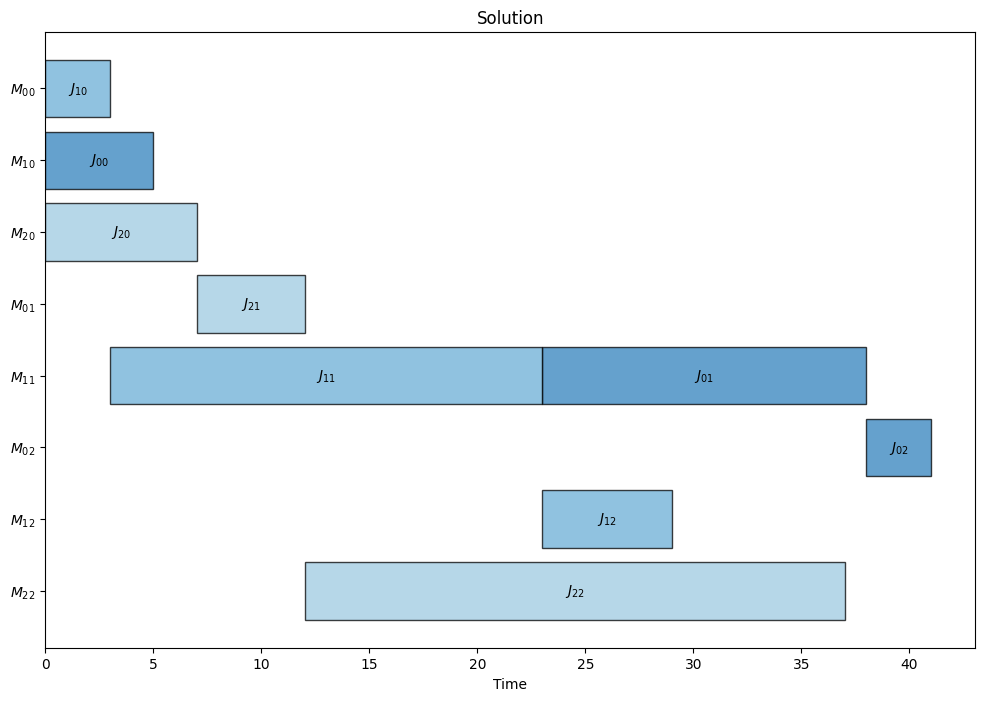

In [69]:
from pyjobshop import plot

data = model.data()
plot(data, result.solution, plot_labels=True)